## Gate optimization

The goal of this notebook is to use machine learning techniques to optimize pulse sequences for the emulation of digital gates on neutral-atom platforms with always-on interaction.

For that purpose, we will use `PulserDiff`, a differentiable backend tailored for optimizing neutral-atom simulations.

More precisely, we want to find three parameter functions: $\Omega(t)$, $\delta(t)$ and $\phi(t)$ of the underlying neutral-atom Hamiltonian, such that its evolution in the interval $[0, T]$ is equivalent to the execution of some global rotation gate. For instance, here we target the global Hadamard gate $H^{\otimes n}$.

Since it is not feasible to optimize over an infinite dimensional set of functions, we need to restrict ourselves to a finite dimensional space $E$, and define a differentiable functions from $\mathbb{R}^{n} \rightarrow E$ to compute the gradient of the fidelity with respect to the parameters on $E$.

First, let us import all necessary tools from Pulser and `PulserDiff` and implement a virtual device for the purposes of simulation.

In [1]:
import torch

from torch import Tensor
from pulser import Sequence, Pulse, Register 
from pulser.devices import VirtualDevice
from pulser.waveforms import CustomWaveform
from pulser.channels import Rydberg
from pulser_diff.utils import trace, kron, interpolate_sine

from pulser_diff.model import QuantumModel
from pyqtorch.matrices import HMAT

from pyqtorch.utils import SolverType


MockDevice = VirtualDevice(
    name="MockDevice",
    dimensions=2,
    rydberg_level=60,
    channel_objects=(
        Rydberg.Global(12.566370614359172, 12.566370614359172, max_duration=None),
    ),
)

### Optimization using constant-pulse sequences

In this tutorial, we will first optimize constant-pulse sequences to retrieve results presented in the article ["Variational protocols for emulating digital gates using analog control with always-on interactions"](https://arxiv.org/pdf/2402.07653).

As a proof of concept, let us start with a simple 2-qubit register and draw it.

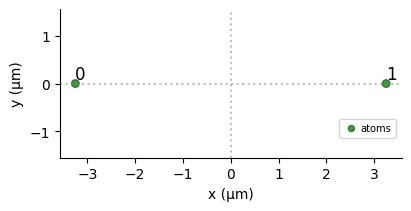

In [2]:
n_qubits = 2
dist = torch.tensor([6.5], requires_grad=False)
reg = Register.rectangle(1, n_qubits, spacing=dist)
reg.draw()

Next, we create the target Hadamard gate and define the gate infidelity function to serve as a minimizing loss.

In [11]:
# The global Hadamard gate is the target gate for the optimization.
target_gate = kron(*[HMAT for _ in range(n_qubits)])

def gate_infidelity(U: Tensor, V: Tensor) -> Tensor:
    dim = U.shape[0]
    return 1 - (1 / dim) * abs(trace(torch.matmul(U.mH, V)))

Now we create an optimizable sequence from a collection of $N=8$ constant pulses with parametrized amplitude $\Omega_i$, detuning $\delta_i$ and phase $\phi_i$ for $i \in \{0, 1, ..., N-1]$.

In [12]:
seq_duration = 1050
n_pulses = 8

seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# Declare sequence variables to be optimized as a dict.
seq_vars = {}
seq_vars["amp_params"] = [seq.declare_variable(f"amp_param_{i}") for i in range(n_pulses)]
seq_vars["det_params"] = [seq.declare_variable(f"det_param_{i}") for i in range(n_pulses)]
seq_vars["phase_params"] = [seq.declare_variable(f"phase_param_{i}") for i in range(n_pulses)]

# Add parameterized constant pulses to the sequence.
for i in range(n_pulses):
    seq.add(
        Pulse.ConstantPulse(
            duration=seq_duration // n_pulses,
            amplitude=seq_vars["amp_params"][i], 
            detuning=seq_vars["det_params"][i], 
            phase=seq_vars["phase_params"][i]
        ), 
        "rydberg_global"
    )

For a more realistic simulation, we add device constraints for the range of allowed amplitude and detuning values. These values are provided by the `MockDevice` specification. Note, that in order to simulate the complete matrix representing the target quantum gate, we need to provide a custom batch of initial states for the `QuantumModel`. Each batch element contributes to a column in the final gate matrix. 

In [13]:
# Extract variable names for the optimizable parameters.
var_names = [var.var.name for var_list in seq_vars.values() for var in var_list]

# Create a constraints dict (phase is unconstrained since it's related to the detuning).
constraints = {}
for name in var_names:
    if "amp" in name:
        # Apply device amplitude constraint.
        constraints[name] = {"min": 0.0, "max": int(MockDevice.channels["rydberg_global"].max_amp)}
    if "det" in name:
        # Apply device detuning constraint.
        constraints[name] = {"min": -MockDevice.channels["rydberg_global"].max_abs_detuning, "max": MockDevice.channels["rydberg_global"].max_abs_detuning}

# Set initial values for the optimizable parameters. Values are fixed for better convergence.
trainable_params = {name: torch.tensor(5.0) for name in var_names}

# Create batch tensor of all possible initial states.
init_state = torch.eye(2 ** n_qubits)

model = QuantumModel(
    seq,
    sampling_rate=0.05,
    trainable_param_values=trainable_params,
    constraints=constraints,
    solver=SolverType.DP5_SE,
    initial_state=init_state)

Finally, let's execute a simple optimization loop for 600 epochs or until the loss drops below 0.0009, for an optimized gate with 99.91% fidelity.

In [14]:
# Define parameter values and initialize the optimizer and the scheduler.
initial_lr = 1.0
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
epochs = 1000
min_change = 0.01
num_loss_plateu = 6

loss_dict = {}
for t in range(epochs):
    # Calculate the loss with the final state.
    _, gate = model.forward()
    loss = gate_infidelity(target_gate, gate[-1])  # we are interested in the final state infidelity
    
    # Backpropagation.
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Log the loss value together with model params.
    loss_dict[t] = {"loss": float(loss), "params": {name: param.data.clone().detach() for name, param in model.named_parameters()}}

    if len(loss_dict) > num_loss_plateu and loss > 0.1:
        last_losses = [loss_dict[i]["loss"] for i in range(t-num_loss_plateu, t + 1)]
        diffs = [abs(last_losses[i] - last_losses[i - 1]) for i in range(-1, -num_loss_plateu-1, -1)]
        if all(diff < min_change for diff in diffs):
            # Reset the learning rate to the initial value and recreate the scheduler.
            for param_group in optimizer.param_groups:
                param_group['lr'] = initial_lr
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
        else:
            # Update the learning rate.
            scheduler.step()
    else:
        # Update the learning rate.
        scheduler.step()

    # Enforce constraints on optimizable parameters.
    model.check_constraints()

    if loss < 0.0009:
        print(f"[t={t}]loss: {float(loss):>7f}")
        break

    # Update the sequence with changed pulse parameter values.
    model.update_sequence()

    if (t % 50 == 0) or (t == epochs-1):
        # Print the learning rate.
        lr = scheduler.get_last_lr()[0]
        print(f"Epoch {t:03}: Learning Rate = {lr:.6f}")

        print(f"[t={t}]loss: {float(loss):>7f}")
        print("**************************************")

# Get the best parameter set.
sorted_losses = dict(sorted(loss_dict.items(), key=lambda x: x[1]["loss"]))
best_param_set = list(sorted_losses.values())[0]["params"]
print(f"Best loss: {list(sorted_losses.values())[0]['loss']} after {list(sorted_losses.keys())[0]} epochs.")

Epoch 000: Learning Rate = 0.999013
[t=0]loss: 0.867522
**************************************
Epoch 050: Learning Rate = 0.000987
[t=50]loss: 0.006605
**************************************
Epoch 100: Learning Rate = 0.999013
[t=100]loss: 0.004576
**************************************
Epoch 150: Learning Rate = 0.000987
[t=150]loss: 0.004507
**************************************
Epoch 200: Learning Rate = 0.999013
[t=200]loss: 0.004503
**************************************
Epoch 250: Learning Rate = 0.000987
[t=250]loss: 0.004502
**************************************
Epoch 300: Learning Rate = 0.999013
[t=300]loss: 0.004502
**************************************
Epoch 350: Learning Rate = 0.000987
[t=350]loss: 0.004502
**************************************
Epoch 400: Learning Rate = 0.999013
[t=400]loss: 0.004748
**************************************
Epoch 450: Learning Rate = 0.000987
[t=450]loss: 0.004565
**************************************
Epoch 500: Learning Rate = 0.9990

In [17]:
# Update the model params with the best optimized parameter values.
for n, p in model.named_parameters():
    p.data = best_param_set[n]
model.check_constraints()
model.update_sequence()

Finally, let's plot the pulse sequence and retrieve parameter values.

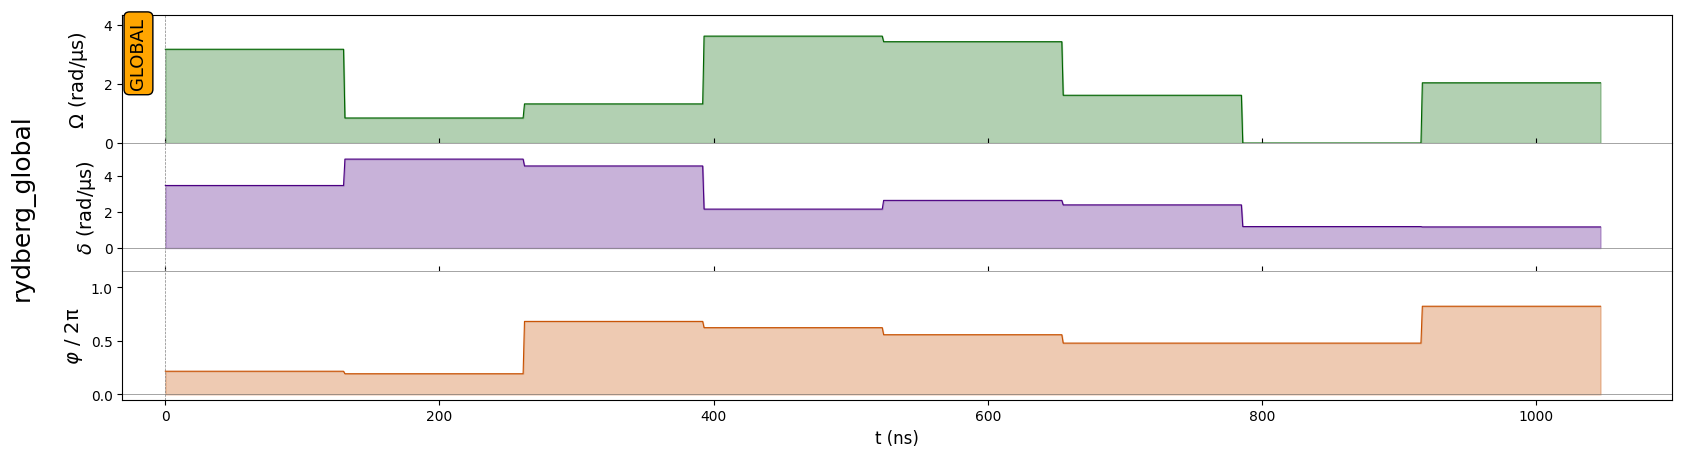

seq_param_values.det_param_6
Parameter containing:
tensor(1.1914, requires_grad=True)
----------------
seq_param_values.det_param_7
Parameter containing:
tensor(1.1712, requires_grad=True)
----------------
seq_param_values.phase_param_6
Parameter containing:
tensor(5.0574, requires_grad=True)
----------------
seq_param_values.det_param_4
Parameter containing:
tensor(2.6439, requires_grad=True)
----------------
seq_param_values.amp_param_4
Parameter containing:
tensor(3.4353, requires_grad=True)
----------------
seq_param_values.phase_param_2
Parameter containing:
tensor(4.2875, requires_grad=True)
----------------
seq_param_values.amp_param_1
Parameter containing:
tensor(0.8496, requires_grad=True)
----------------
seq_param_values.phase_param_5
Parameter containing:
tensor(3.0125, requires_grad=True)
----------------
seq_param_values.phase_param_3
Parameter containing:
tensor(3.9201, requires_grad=True)
----------------
seq_param_values.det_param_2
Parameter containing:
tensor(4.5551,

In [18]:
model.built_seq.draw(draw_phase_curve=True)

for name, param in model.named_parameters():
    print(name)
    print(param)
    print("----------------")

_, gate = model.forward()
print(f"Gate fidelity: {100*(1 - float(gate_infidelity(gate[-1], target_gate))):.2f}%")


As we can see the fidelity of the simulated Hadamard gate is 99.91%, on par with the results presented in the paper.

### Optimization using custom-waveform pulse sequences

Ideal constant pulses are not exactly implementable on a real quantum device. The gate optimization problem should generate more realistic, smoother pulse shapes. To achieve this, we sample $N$ points at times $\{t_n\}_{n\in[1,N]}$ representing values of the pulse amplitude $\Omega_i$ and then sine-interpolate for the missing ones. Generally, in `PulserDiff`, the complete continuous function $\Omega(t)$ is not needed, but only discrete samples at $t_k$ where $k \in \{1,2,...,T\}$ with $T$ being the total duration of the sequence. The reason being that the underlying `pulser-core` engine discretizes any sequence in 1 ns steps.

Let us define the interpolation procedure more rigorously. We start from a sample set of values $\{\theta_i\}_{i\in[n,N]}$ that serve as parameters governing the shape of the resulting waveform. The goal is to construct a function $\Omega(t)$ such that $\Omega(t_n) = \theta_n$. To ensure smoothness and continuity, we use the sine transition function defined as:

$$
s(t) = \frac{1 + \sin(\pi t - \frac{\pi}{2})}{2}.
$$ 

This function transitions smoothly from 0 to 1 as $t \in [0, 1]$, and has continuous first derivatives. Now, for any time $t \in [t_k, t_{k+1}]$, we define:

$$
\Omega(t) = \theta_k (1 - s(h)) + \theta_{k+1} s(h)
$$

where $h = \frac{t - t_k}{t_{k+1} - t_k} \in [0, 1]$. This ensures that $\Omega(t)$ is continuously differentiable and satisfies the interpolation condition $\Omega(t_n) = \theta_n$. Since $\Omega(t)$ is a linear combination of parameters $\theta_n$, the entire function is linearly dependent on the vector of parameters $\mathbf{\theta}$. Since any sequence in `PulserDiff` is discretized in 1 ns steps we can precompute a matrix $A \in \mathbb{R}^{T \times N}$ such that the value of the waveform at a time $t_k$ is given by:

$$
\Omega(t_k) = (\mathbf{A} \cdot \mathbf{\theta})_k
$$

where $\Omega_k$ is the interpolated value at time $t_k$. 

The algorithm described above is implemented in function `interpolate_sine()` that can be imported from the `pulser_diff.utils` module.


Let us now explore a slightly more involved example of pulse optimization with a register consisting of 4 qubits and define the target gate as before: the tensor product of single-qubit Hadamard gates.

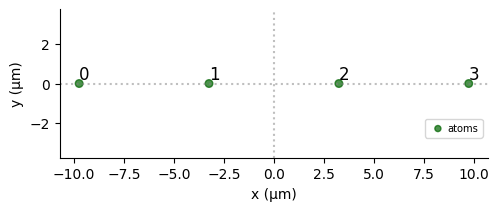

In [19]:
# Create a register with 4 qubits.
n_qubits = 4
dist = torch.tensor([6.5], requires_grad=False)
reg = Register.rectangle(1, n_qubits, spacing=dist)
reg.draw()

# Create the corresponding target Hadamard gate.
target_gate = kron(*[HMAT for _ in range(n_qubits)])

# Create a tensor of batched initial states to get the complete gate matrix on output.
init_state = torch.eye(2**n_qubits)

In contrast with the previous case where we used 8 constant pulses in the parametrized sequence, now the sequence contains a single pulse with custom waveforms for the amplitude and detuning defined with Pulser's `CustomWaveform` object. The interpolation matrix is used in the definition of the functions `custom_wf_amp()` and `custom_wf_det()` that are responsible for calculation of the actual values of the corresponding waveforms. 

Note that in the function `custom_wf_amp()` a `torch.sigmoid()` function is used to confine control parameters in the range $[0, \Omega_{\rm{max}}]$ where $\Omega_{\rm{max}}$ is the maximum amplitude allowed by the device used to create the sequence. Although `PulserDiff` currently supports constraints on trainable parameters, amplitude values are now calculated *from* user-supplied trainable parameters and the `check_constraints()` method in the `QuantumModel` does not apply in this case.


call_param_values.amp_custom_0
Parameter containing:
tensor([-0.6990, -1.1266,  0.2312,  1.7064,  2.3403, -0.6907, -0.5883,  1.0251,
        -0.4023,  0.2918, -2.0087,  1.2236, -1.6916, -1.1019,  0.8537, -1.5967,
         0.6686,  1.5748, -1.4093, -0.9600], requires_grad=True)
-------
call_param_values.det_custom_0
Parameter containing:
tensor([-0.7758,  0.8404,  1.1174, -1.0271, -1.5233, -1.3598, -2.3105,  2.4627,
         0.5028, -1.3735, -0.1984,  1.9218,  0.3765, -1.7813,  0.8958,  0.2888,
        -0.0547, -0.8894,  1.7436,  1.4294], requires_grad=True)
-------


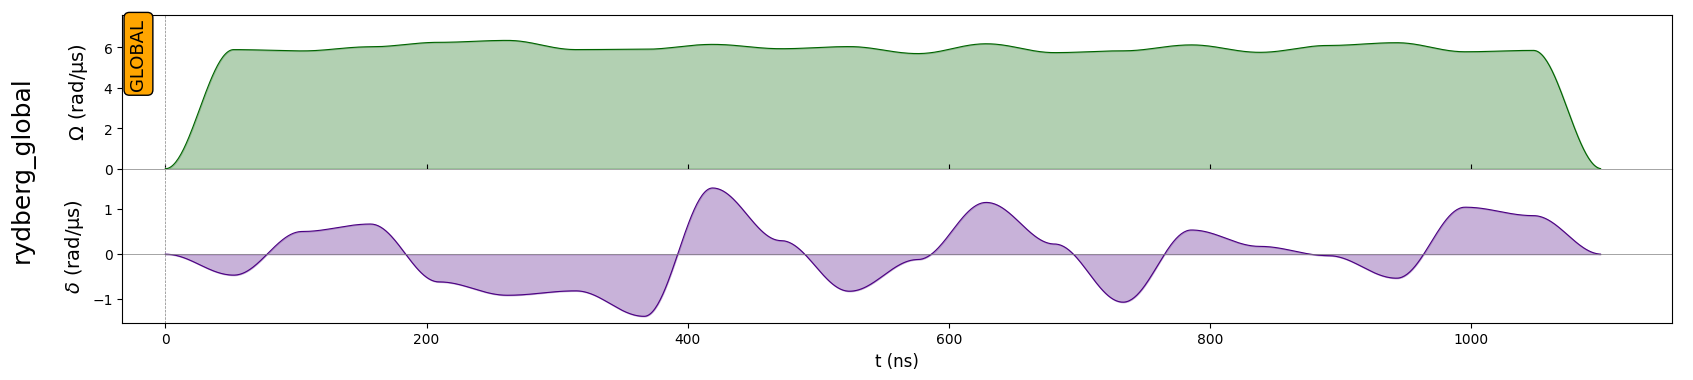

In [21]:
# Define sequence parameters.
duration = 1100
n_param = 20
gamma = 0.05

# Create a sequence and declare channels.
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# Define a custom-shaped pulse.
amp_custom_param = seq.declare_variable("amp_custom", size=duration)
det_custom_param = seq.declare_variable("det_custom", size=duration)
cust_amp = CustomWaveform(amp_custom_param)
cust_det = CustomWaveform(det_custom_param)
pulse_custom = Pulse(cust_amp, cust_det, 0.0)

# Add pulse to the sequence.
seq.add(pulse_custom, "rydberg_global")

# Create the sine interpolation matrix.
interp_mat = interpolate_sine(n_param, duration)

# Define the waveform functions.
def custom_wf_amp(params):
    return torch.matmul(interp_mat, int(MockDevice.channels["rydberg_global"].max_amp) * torch.sigmoid(gamma * params))

def custom_wf_det(params):
    return torch.matmul(interp_mat, int(MockDevice.channels["rydberg_global"].max_abs_detuning) * torch.tanh(gamma * params))

# Define the pulse parameters.
amp_values = 5 * torch.rand(n_param, requires_grad=True) - 2.5
det_values = 5 * torch.rand(n_param, requires_grad=True) - 2.5
trainable_params = {
    "amp_custom": ((amp_values,), custom_wf_amp),
    "det_custom": ((det_values,), custom_wf_det),
}

# Create a quantum model from the sequence.
model = QuantumModel(seq, trainable_params, sampling_rate=0.05, solver=SolverType.DP5_SE, initial_state=init_state)

# List trainable parameters of the model.
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')

# Draw the initial sequence.
model.built_seq.draw()

We can see from the figure above that the initial waveforms are indeed smooth functions that are governed by $N=20$ parameters each.

Let us now define the optimization loop. In this case we use the `CosineAnnealingLR` learning rate scheduler available in `torch` to help with the optimization in the more complex loss lansdcape of the 4-qubit system. We also implement a check for loss plateaus: the state of the learning rate scheduler resets to the initial high value when the loss does not decrease rapidly enough. This procedure helps in getting away from plateaus and avoiding local minima. Another measure from standard ML practices is logging the loss value together with the corresponding model parameters. This allows to choose the best set of parameters encountered throughout the scheduled optimization procedure.

In [22]:
# Define parameter values and initialize the optimizer and the scheduler.
initial_lr = 5.0
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
epochs = 1000
min_change = 0.01
num_loss_plateu = 6

loss_dict = {}
for t in range(epochs):
    # Calculate the loss with the final state.
    _, gate = model.forward()
    loss = gate_infidelity(target_gate, gate[-1])
    
    # Backpropagation.
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Log the loss value together with model params.
    loss_dict[t] = {"loss": float(loss), "params": {name: param.data.clone().detach() for name, param in model.named_parameters()}}

    if len(loss_dict) > num_loss_plateu and loss > 0.1:
        last_losses = [loss_dict[i]["loss"] for i in range(t-num_loss_plateu, t + 1)]
        diffs = [abs(last_losses[i] - last_losses[i - 1]) for i in range(-1, -num_loss_plateu-1, -1)]
        if all(diff < min_change for diff in diffs):
            # Reset the learning rate to the initial value and recreate the scheduler.
            for param_group in optimizer.param_groups:
                param_group['lr'] = initial_lr
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
        else:
            # Update the learning rate.
            scheduler.step()
    else:
        # Update the learning rate.
        scheduler.step()

    if loss < 0.0001:
        print(f"[t={t}]loss: {float(loss):>7f}")
        break

    # Update the sequence with changed pulse parameter values.
    model.update_sequence()

    if (t % 50 == 0) or (t == epochs-1):
        # Print the learning rate.
        lr = scheduler.get_last_lr()[0]
        print(f"Epoch {t:03}: Learning Rate = {lr:.6f}")

        print(f"[t={t}]loss: {float(loss):>7f}")
        print("**************************************")

# Get the best parameter set.
sorted_losses = dict(sorted(loss_dict.items(), key=lambda x: x[1]["loss"]))
best_param_set = list(sorted_losses.values())[0]["params"]
print(f"Best loss: {list(sorted_losses.values())[0]['loss']} after {list(sorted_losses.keys())[0]} epochs.")

Epoch 000: Learning Rate = 4.995067
[t=0]loss: 0.906707
**************************************
Epoch 050: Learning Rate = 0.004933
[t=50]loss: 0.013457
**************************************
Epoch 100: Learning Rate = 4.995067
[t=100]loss: 0.002192
**************************************
Epoch 150: Learning Rate = 0.004933
[t=150]loss: 0.001843
**************************************
Epoch 200: Learning Rate = 4.995067
[t=200]loss: 0.001782
**************************************
Epoch 250: Learning Rate = 0.004933
[t=250]loss: 0.001730
**************************************
Epoch 300: Learning Rate = 4.995067
[t=300]loss: 0.001687
**************************************
Epoch 350: Learning Rate = 0.004933
[t=350]loss: 0.001650
**************************************
Epoch 400: Learning Rate = 4.995067
[t=400]loss: 0.001620
**************************************
Epoch 450: Learning Rate = 0.004933
[t=450]loss: 0.001594
**************************************
Epoch 500: Learning Rate = 4.9950

After the optimization completion, we select the best set of parameters and update the model with these values.

In [23]:
# update model params with the best optimized parameter values
for n, p in model.named_parameters():
    p.data = best_param_set[n]
model.update_sequence()

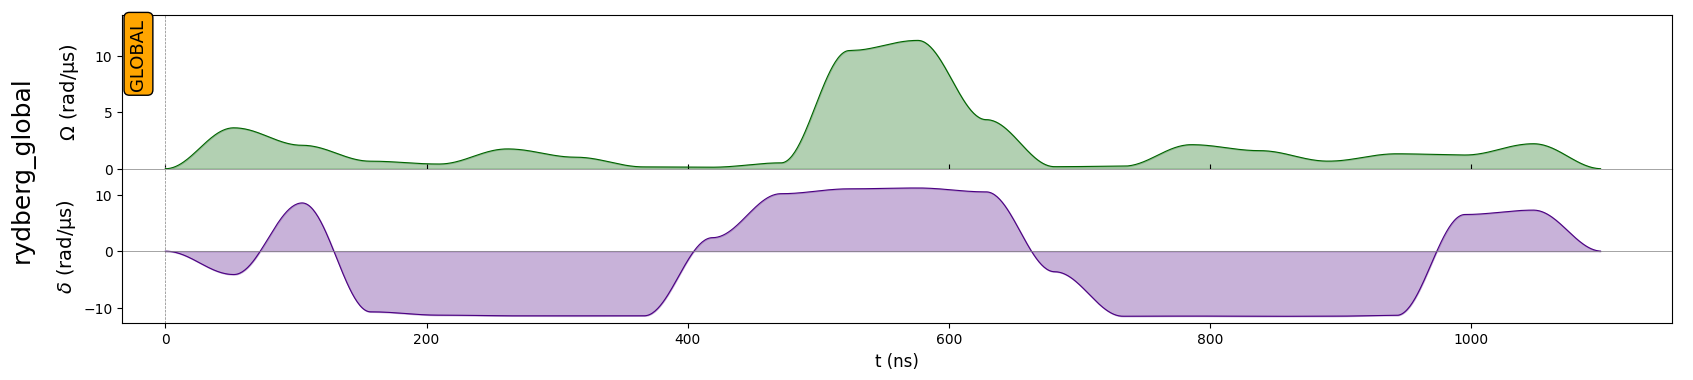

call_param_values.amp_custom_0
Parameter containing:
tensor([-16.8346, -31.3419, -56.6626, -66.5125, -35.3561, -47.5504, -85.9064,
        -89.2980, -61.9608,  38.0063,  56.7492, -11.3899, -83.5173, -79.3703,
        -30.7206, -37.4819, -56.5160, -41.8274, -43.7010, -29.7942],
       requires_grad=True)
----------------
call_param_values.det_custom_0
Parameter containing:
tensor([ -7.1687,  17.7202, -28.7036, -34.9884, -36.9152, -37.2416, -36.8077,
          4.0282,  24.8121,  31.4093,  33.0967,  26.8384,  -6.2463, -38.2686,
        -37.7148, -38.5522, -38.2611, -35.5587,  12.0700,  13.9825],
       requires_grad=True)
----------------
Gate fidelity: 99.85%


In [24]:
# Draw the optimized custom pulse.
model.built_seq.draw(draw_phase_curve=True)

for name, param in model.named_parameters():
    print(name)
    print(param)
    print("----------------")

_, gate = model.forward()
print(f"Gate fidelity: {100*(1 - float(gate_infidelity(gate[-1], target_gate))):.2f}%")

We can see that the shape of the initial amplitude and detuning waveforms changed drastically to achieve a very respectable 99.84% gate fidelity.